In [1]:
from MultiTimeframeCandleManager import MultiTimeframeCandleManager
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

candles = obj_load("NQ_2")
len(candles)

loading NQ_2


2000000

In [2]:
gamma = 0.99
memory_len = 100000
batch_size = 512
e = 2

num_actions = 3

path = "./"

ep_len = 1000

m1 = np.eye(num_actions, dtype="float32")
num_model_inputs = 6

In [3]:
chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (19+12*5,))

current_position = tf.keras.layers.Input(shape = (1,))
#scaled_open_profit = tf.keras.layers.Input(shape = (1,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position])

lrelu = tf.keras.layers.LeakyReLU(0.05)

d = tf.keras.layers.Dense(1024*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dense(1024*4)(d)
d = lrelu(d)


value = tf.keras.layers.Dense(1, activation="linear")(d)
advantage = tf.keras.layers.Dense(num_actions, activation="linear")(d)

q_values = tf.keras.layers.Lambda(
lambda inputs: inputs[0] + (inputs[1] - tf.reduce_mean(inputs[1], axis=1, keepdims=True))
)([value, advantage])



model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = q_values)
target_model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position], outputs = q_values)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000001)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 60, 4)]      0           []                               
                                                                                              

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

In [5]:

def relative (value, center, r):
        return (value - center) / r

def ret_to_scaled_inputs(ret):

    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
    

    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = max(0.0001,(midnight_opening_range_high - midnight_opening_range_low) / 2)

    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas[0:18]:
        pda_rel.append(relative(pda, center, r))
    for index in range(18,18+5*12):
        ## highs lows are like this [h, h_taken, l, l_taken]
        ## the bools should not be scaled
        if (index - 18) % 2 == 0:
            pda_rel.append(relative(pdas[index], center, r))
        else:
            pda_rel.append(pdas[index])
    
    pda_np = np.array(pda_rel)

    current_minutes = current_time.hour * 60 + current_time.minute

    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])

    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]

In [6]:
class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction
    

In [7]:
m = MultiTimeframeCandleManager()

current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

cmm = 0.5

last_state = None
last_action = 0

index = 0

def step():

    global index, last_state, last_action, current_position, current_order, equity, m


    sarts = None
    while  sarts == None:

        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse        
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
                
        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

    
        

        if(len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):

            
            open_profit = (current_close - current_position.entry) * current_position.direction


            state = ret_to_scaled_inputs(ret) + [current_position.direction]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos = state

            if(last_state != None):
                diff = (equity+open_profit) - equity_L[-1]
                equity_L.append(equity+open_profit)
                reward =  (diff) / r
                terminal = 0
                if(index+1 == len(candles)):
                    terminal = 1

                sarts = last_state, last_action, reward, terminal, state


            if(random.randint(0,100) > e):
                output = model([
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    tf.expand_dims(pos, 0)
                ])

                last_action = np.argmax(output)
            else:
                last_action = random.randint(0,num_actions-1)

            last_state = state

            if(last_action == 2 and current_position.direction != 0):    
                equity += open_profit
                current_position = Position(0,0,0,0)
            
            if(last_action == 0 and current_position.direction == 1):    
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0 and current_position.direction == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None
                    
                pdas = m.normal_pdas ## (low, high)
                
                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) >= 3):
                    ### sl is the high of 3 pdas
                    sl = sorted_by_high[2][1]

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)

                    tp = entry  -  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, -1)
                    #print("set short order:",entry,sl,tp)

                    

            if(last_action == 1 and current_position.direction == -1):    
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1 and current_position.direction == 0):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)
                
                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) >= 3):
                    ### sl is the high of 3 pdas
                    sl = sorted_by_low[2][0]

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    tp = entry  +  abs(entry-sl) * 1000

                    current_order = Order(entry, sl, tp, 1)
                    #print("set long order:",entry,sl,tp)
                




        index += 1
        if(index == len(candles)):
            index = 0
            current_position = Position(0,0,0,0)
            last_state = None
            last_action = 0
            m = MultiTimeframeCandleManager()
            print("env reset")

    return sarts

In [8]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]    
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")

2 0.0 0


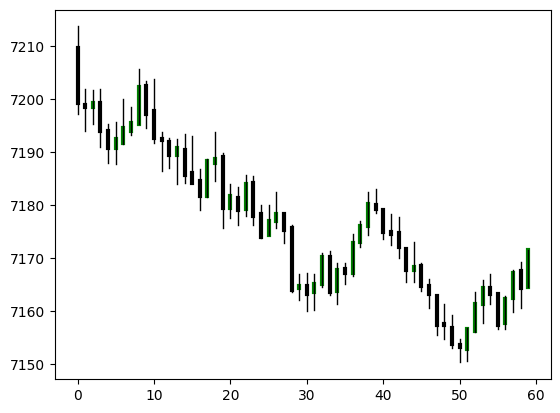

In [9]:
sarts = step()

plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")

if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")


print(sarts[1], sarts[2], current_position.direction)

In [10]:
@tf.function()
def get_target_q(next_states, rewards, terminals):
            estimated_q_values_next = target_model(next_states)
            q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
            target_q_values = q_batch * gamma * (1-terminals) + rewards
            return target_q_values

@tf.function()
def tstep(states, masks, rewards, terminals, next_states):

    target_q_values = get_target_q(next_states, rewards, terminals)

    with tf.GradientTape() as t:
        model_return = model(states, training=True)
        mask_return = model_return * masks
        estimated_q_values = tf.math.reduce_sum(mask_return, axis=1)
        #print(estimated_q_values, mask_return, model_return, masks)
        loss_e = tf.math.square(target_q_values - estimated_q_values)
        loss = tf.reduce_mean(loss_e)


    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss, tf.reduce_mean(estimated_q_values)

In [11]:
def run():
    sarts = step()
    sarts_memory.append(sarts)

    if(len(sarts_memory) > batch_size):
        #sarts_sample = random.sample(sarts_memory, batch_size)
        
        r = random.randint(0, len(sarts_memory) - batch_size)
        sarts_sample = [sarts_memory[i] for i in range(r, r + batch_size)]

    
        states = [x[0] for x in sarts_sample]
        actions = [x[1] for x in sarts_sample]
        rewards = np.array([x[2] for x in sarts_sample], dtype="float32")
        terminals = np.array([x[3] for x in sarts_sample], dtype="float32")
        next_states = [x[4] for x in sarts_sample]
    
        next_states_array = []
        for i in range(num_model_inputs):
            next_states_array.append(np.array([x[i] for x in next_states], dtype = "float32"))
    
    
        states_array = []
        for i in range(num_model_inputs):
            states_array.append(np.array([x[i] for x in states], dtype = "float32"))
    
    
        masks = np.array(m1[actions], dtype="float32")
    
        loss, q = tstep(states_array, masks, rewards, terminals, next_states_array)

        return loss, q, sarts[2], sarts[1]
    else :
        return 0,0,0,0

In [12]:
sarts_memory = deque(maxlen = memory_len)

loss_mean = []
q_mean = []
rewards = []

try:
    model.load_weights(path+"model.weights.h5")
    target_model.load_weights(path+"model.weights.h5")

    loss_mean = obj_load(path+"loss")
    q_mean = obj_load(path+"q")
    rewards = obj_load(path+"rewards")
except:
    print("unable to load data")

loading ./loss
loading ./q
loading ./rewards


In [13]:
def save():
            model.save_weights(path+"model.weights.h5")
            obj_save(loss_mean, path+"loss")
            obj_save(q_mean, path+"q")
            obj_save(rewards, path+"rewards")
            print("saved progress")

In [ ]:
safe_after_eps = 10
eps_counter=0

while True:
    eps_counter+=1
    try:
        loss = []
        q = []
        rewards_tmp = []
        actions = []
        progbar = tf.keras.utils.Progbar(ep_len)
        for i in range(ep_len):
            c_loss, c_q, c_rewards, c_action = run()
            loss.append(c_loss)
            q.append(c_q)
            #rewards_tmp.append(c_rewards)
            rewards.append(c_rewards)
            actions.append(c_action)

            progbar.update(i+1, values = [("loss", c_loss), ("qv", c_q), ("reward", c_rewards), ("avg_action", c_action)])

        loss_mean.append(np.mean(loss))
        q_mean.append(np.mean(q))
        #rewards.append(np.mean(rewards_tmp))
        
        #progbar.update(ep_len, values = [("loss", np.mean(loss)), ("qv", np.mean(q)), ("reward", np.mean(rewards)), ("avg_action", np.mean(actions))])

        target_model.set_weights(model.get_weights())

        if(eps_counter >= safe_after_eps):
            eps_counter = 0
            save()


    except    KeyboardInterrupt:
        print("")
        print("exit")
        save()
        break


  21/1000 [..............................] - ETA: 44s - loss: 1.4680 - qv: 34.9212 - reward: -0.2206 - avg_action: 0.0952    